In [299]:
import os

from skimage import io, transform

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

In [300]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device}")

Using cuda


In [301]:
IMAGE_SIZE = 128 #Actual frames = 1440. must be power of 2
IMAGE_CHANNELS = 3
LATENT_VECTOR_SIZE = 100

Set the random seed:

In [302]:
torch.manual_seed(1337)

In [303]:
def show_examples(model, title=None, big=False):
    latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
    generated_samples = model(latent_space_samples)

    generated_samples = generated_samples.detach()
    fig = plt.figure()
    if title:
        fig.text(0.5, 1.0 if big else 0.7, title, ha='center', va='center')
    for plot_idx, dataset_idx  in enumerate(torch.randint(len(generated_samples), (12 if big else 4,))):
        sub = plt.subplot(3 if big else 1, 4, plot_idx+1)
        plt.tight_layout()
        sub.axis('off')
        image = generated_samples[dataset_idx.item()].permute(1,2,0)
        plt.imshow(image *0.5 + 0.5)
    fig.show()

# Preparing training data

In [304]:
class VetleDataset(Dataset):

    def __init__(self, sample_count, image_dir, transform=None):
        """
        Arguments:
            sample_count (int): How many samples
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sample_count = sample_count
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return self.sample_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        frameno = str(idx+1).zfill(4)
        filename = "frame" + frameno + ".png"

        img_name = os.path.join(self.image_dir,
                                filename)
        image = torchvision.io.read_image(img_name).float()
        

        if self.transform:
            image = self.transform(image)

        # Return image with a label. We won't use it, but it seems like tensorflow expects it
        return [image,0]

In [305]:
vetleTransform = transforms.Compose([ transforms.Resize(IMAGE_SIZE), transforms.Normalize(128,128)])

In [306]:
vetleDataset = VetleDataset(2905, "assets/frames/", transform=vetleTransform)

In [307]:
flowerTransform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  
    transforms.RandomCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) 
])

In [308]:
flowerDataset = torchvision.datasets.Flowers102(root="assets", download=True, transform=flowerTransform)

In [309]:
SELECTED_DATASET = flowerDataset

Plot training data:

C:\Users\vmang\AppData\Local\Temp\ipykernel_9476\2381701216.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


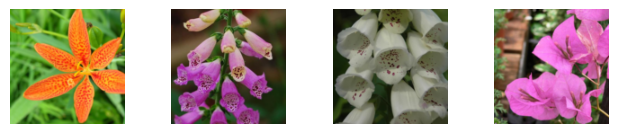

In [310]:
fig = plt.figure()
for plot_idx, dataset_idx  in enumerate(torch.randint(len(SELECTED_DATASET), (4,))):
    sub = plt.subplot(1, 4, plot_idx+1)
    plt.tight_layout()
    sub.axis('off')
    image = SELECTED_DATASET[dataset_idx.item()][0].permute(1,2,0)
    plt.imshow(image * 0.5 + 0.5)
fig.show()

Create data loader:

In [311]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    SELECTED_DATASET, batch_size=batch_size, shuffle=True
)


# The models


## Discriminator

In [312]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() 
        )

    def forward(self, x):
        output = self.model(x)
        return output.view(x.size(0),1)

In [313]:
discriminator = Discriminator()

## Generator

In [314]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
       
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=LATENT_VECTOR_SIZE, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),


            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.view(x.size(0),LATENT_VECTOR_SIZE,1,1)
        return self.model(x)



C:\Users\vmang\AppData\Local\Temp\ipykernel_9476\3816338196.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


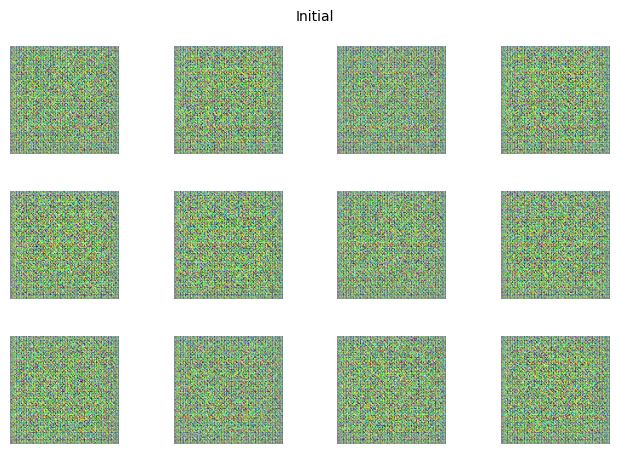

In [315]:
generator = Generator()
show_examples(generator, title="Initial", big=True)

# Training


## Hyperparameters

In [316]:
lr = 0.0002
num_epochs = 300
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))

Loop

0 
Epoch: 0 Loss D.: 6.220936298370361
Epoch: 0 Loss G.: 16.610300064086914


C:\Users\vmang\AppData\Local\Temp\ipykernel_9476\3816338196.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


1 2 3 4 5 6 7 8 9 10 
Epoch: 10 Loss D.: 0.5075787305831909
Epoch: 10 Loss G.: 1.9833652973175049
11 12 13 14 15 16 17 18 19 20 
Epoch: 20 Loss D.: 0.8105611801147461
Epoch: 20 Loss G.: 3.9507243633270264
21 22 23 24 25 26 27 28 29 30 
Epoch: 30 Loss D.: 1.7173490524291992
Epoch: 30 Loss G.: 3.5097498893737793
31 32 33 34 35 36 37 38 39 40 
Epoch: 40 Loss D.: 0.8034625053405762
Epoch: 40 Loss G.: 2.5622804164886475
41 42 43 44 45 46 47 48 49 50 
Epoch: 50 Loss D.: 0.8154000043869019
Epoch: 50 Loss G.: 2.97076416015625
51 52 53 54 55 56 57 58 59 60 
Epoch: 60 Loss D.: 0.7055628299713135
Epoch: 60 Loss G.: 3.291999340057373
61 62 63 64 65 66 67 68 69 70 
Epoch: 70 Loss D.: 0.8557659983634949
Epoch: 70 Loss G.: 1.8416924476623535
71 72 73 74 75 76 77 78 79 80 
Epoch: 80 Loss D.: 1.2260584831237793
Epoch: 80 Loss G.: 4.174261093139648
81 82 83 84 85 86 87 88 89 90 
Epoch: 90 Loss D.: 0.854283332824707
Epoch: 90 Loss G.: 3.135838508605957
91 92 93 94 95 96 97 98 99 100 
Epoch: 100 Loss D.: 

C:\Users\vmang\AppData\Local\Temp\ipykernel_9476\3816338196.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


201 202 203 204 205 206 207 208 209 210 
Epoch: 210 Loss D.: 0.6134374141693115
Epoch: 210 Loss G.: 2.1940841674804688
211 212 213 214 215 216 217 218 219 220 
Epoch: 220 Loss D.: 0.23695378005504608
Epoch: 220 Loss G.: 3.0370264053344727
221 222 223 224 225 226 227 228 229 230 
Epoch: 230 Loss D.: 0.8218015432357788
Epoch: 230 Loss G.: 7.031376361846924
231 232 233 234 235 236 237 238 239 240 
Epoch: 240 Loss D.: 0.3287619948387146
Epoch: 240 Loss G.: 5.200992107391357
241 242 243 244 245 246 247 248 249 250 
Epoch: 250 Loss D.: 1.2409409284591675
Epoch: 250 Loss G.: 4.280461311340332
251 252 253 254 255 256 257 258 259 260 
Epoch: 260 Loss D.: 0.21424007415771484
Epoch: 260 Loss G.: 5.31129789352417
261 262 263 264 265 266 267 268 269 270 
Epoch: 270 Loss D.: 0.37497422099113464
Epoch: 270 Loss G.: 3.170816421508789
271 272 273 274 275 276 277 278 279 280 
Epoch: 280 Loss D.: 0.3926558792591095
Epoch: 280 Loss G.: 5.455007076263428
281 282 283 284 285 286 287 288 289 290 
Epoch: 290 

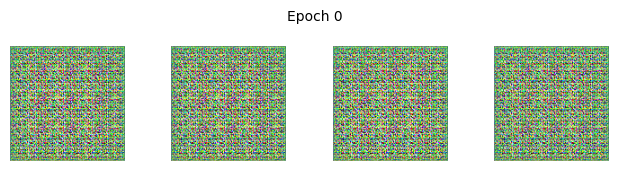

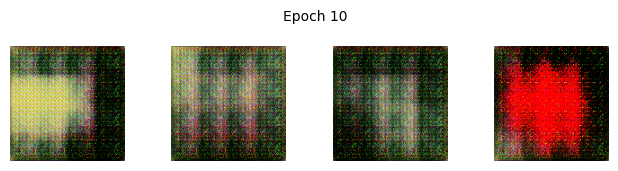

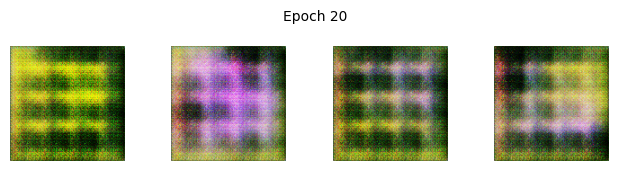

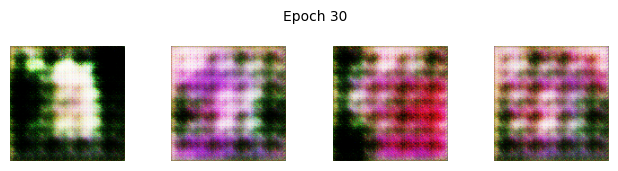

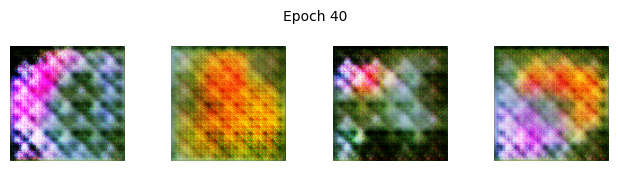

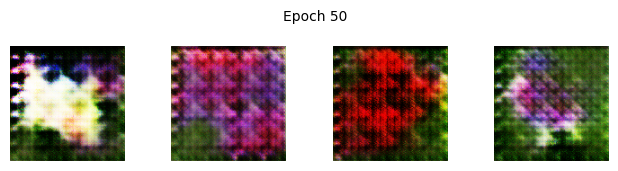

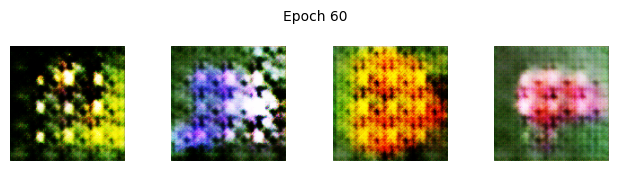

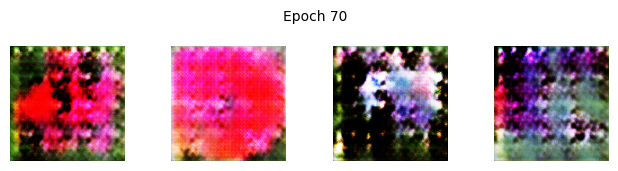

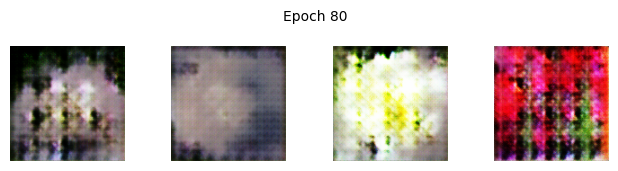

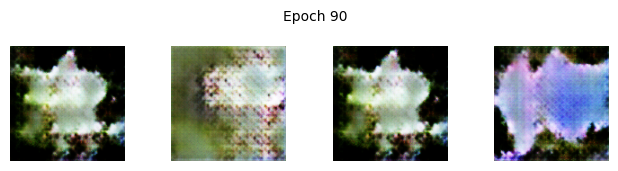

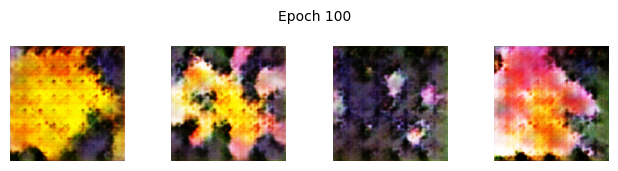

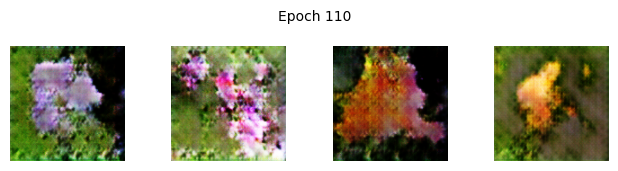

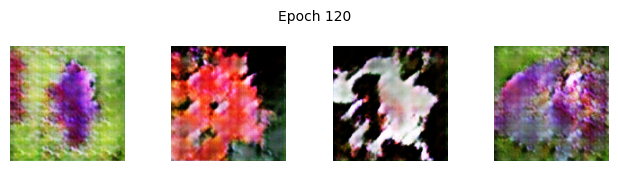

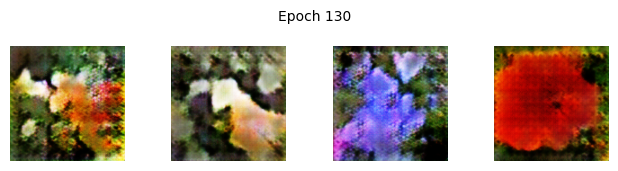

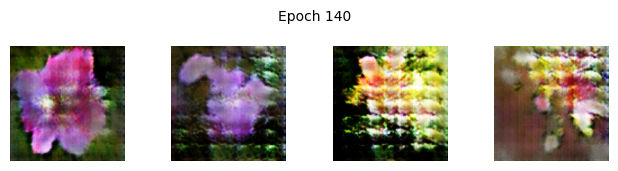

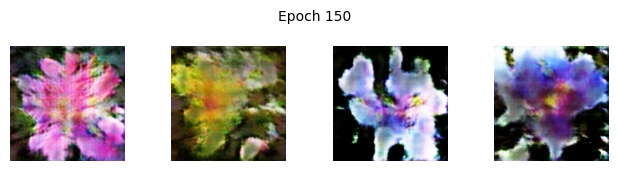

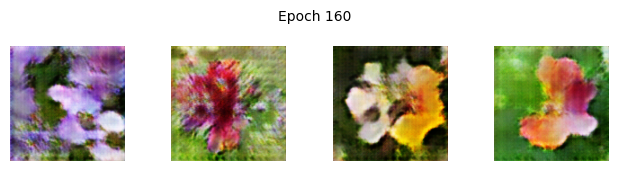

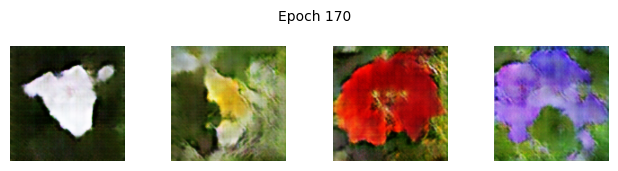

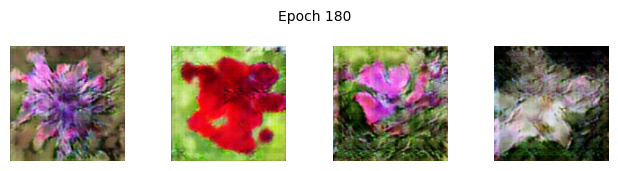

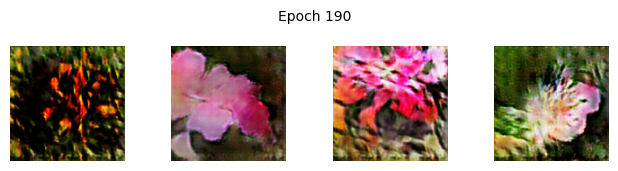

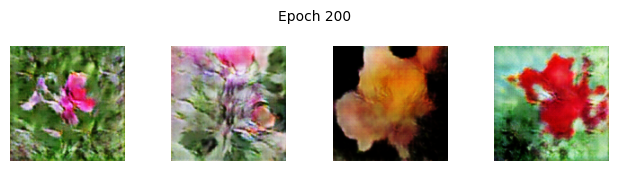

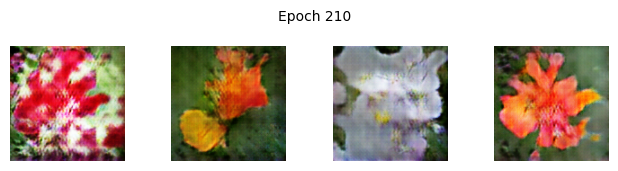

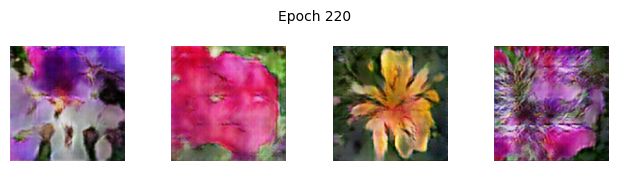

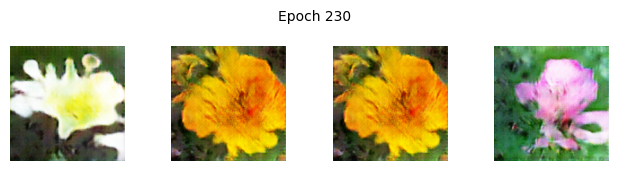

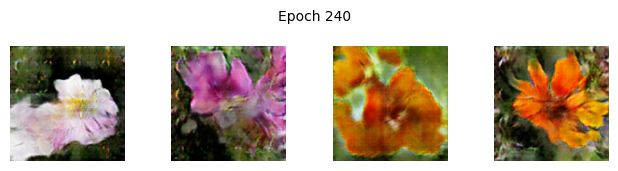

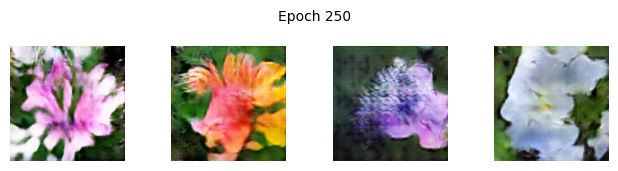

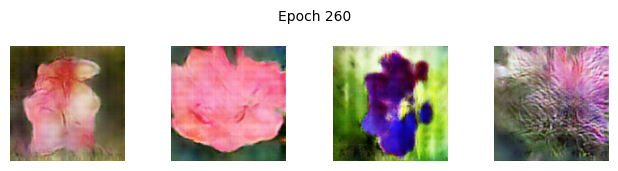

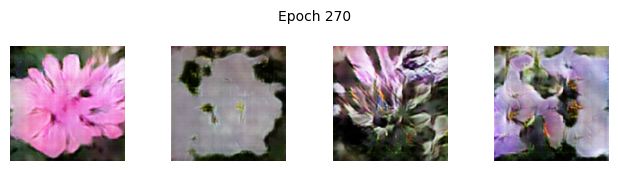

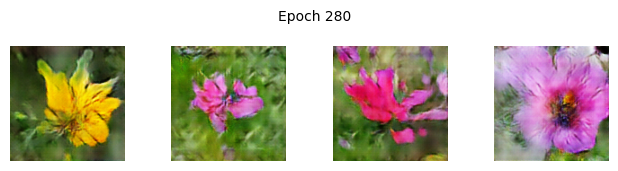

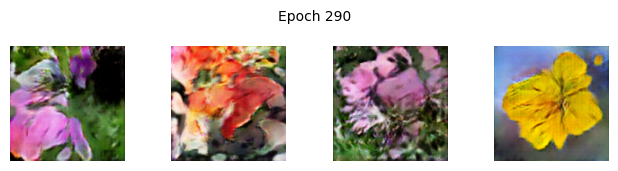

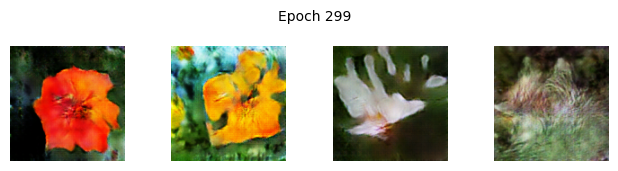

In [317]:
timeline = {
    "loss_discriminator":[],
    "loss_generator":[],
}
for epoch in range(num_epochs):
    print(epoch, end=" ")
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((real_samples.shape[0], 1))
        latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        discriminator_loss = 0
        ## First only real samples
        output_discriminator_real = discriminator(real_samples)
        loss_discriminator_real = loss_function(
            output_discriminator_real, real_samples_labels)
        loss_discriminator_real.backward()
        discriminator_loss += loss_discriminator_real.detach()
        
        ## Then only generated samples
        output_discriminator_gen = discriminator(generated_samples)
        loss_discriminator_gen = loss_function(
            output_discriminator_gen, generated_samples_labels)
        loss_discriminator_gen.backward()
        
        optimizer_discriminator.step()
        discriminator_loss += loss_discriminator_gen.detach()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
        real_labels = torch.ones((batch_size, 1))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == len(train_loader) - 1:
            timeline["loss_discriminator"].append(discriminator_loss)
            timeline["loss_generator"].append(loss_generator.detach())
            if epoch % 10 == 0 or epoch == num_epochs -1:
                print("")
                print(f"Epoch: {epoch} Loss D.: {discriminator_loss}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")
                show_examples(generator, title=f"Epoch {epoch}")
           

# Results

C:\Users\vmang\AppData\Local\Temp\ipykernel_9476\3816338196.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


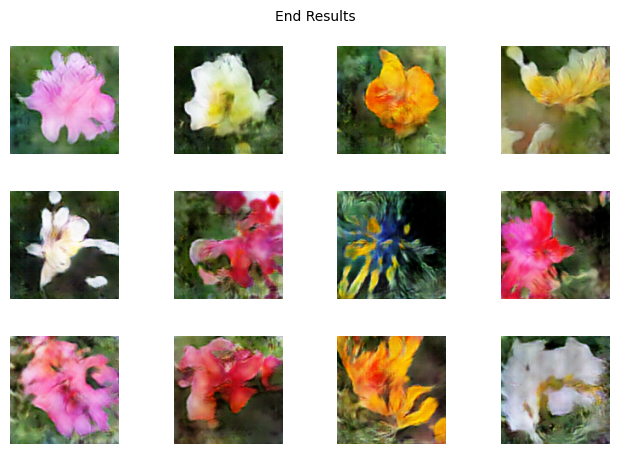

In [318]:
show_examples(generator, title="End Results", big=True)


In [1]:
latent_space_endpoints = torch.randn((2, LATENT_VECTOR_SIZE))

STEPS = 10
latent_space_samples = torch.empty(STEPS, LATENT_VECTOR_SIZE)
for i in range(STEPS):
    latent_space_samples[i] = torch.lerp(latent_space_endpoints[0], latent_space_endpoints[1],float(i)/float(STEPS+10))
print(latent_space_samples.size())

generated_samples = generator(latent_space_samples)
print(generated_samples.size())

generated_samples = generated_samples.detach()
fig, axes = plt.subplots(1, STEPS, figsize=(10,2))  # Adjust width and height for bigger images
fig.text(0.5, 0.8, "Looking at the lerping betweent two flowers", ha='center', va='center')

for i  in range(STEPS):
    sub = plt.subplot(1, STEPS, i+1)
    sub.axis('off')
    image = generated_samples[i].permute(1,2,0)
    axes[i].imshow(image * 0.5 + 0.5)
plt.tight_layout(pad=0.5)
fig.show()

NameError: name 'torch' is not defined

## Stats

C:\Users\vmang\AppData\Local\Temp\ipykernel_9476\3322973481.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  discriminator_plot.show()
C:\Users\vmang\AppData\Local\Temp\ipykernel_9476\3322973481.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  generator_plot.show()


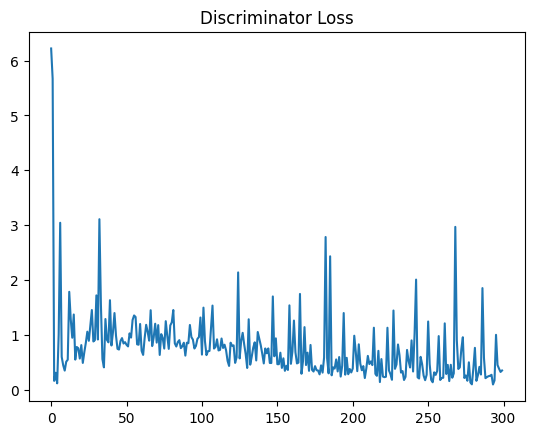

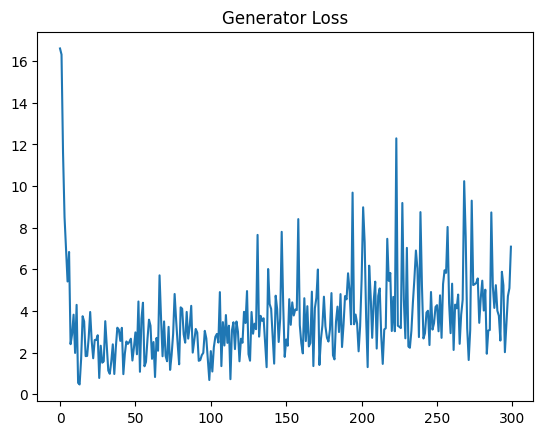

In [320]:
discriminator_plot = plt.figure()
plt.plot(range(0, num_epochs), timeline["loss_discriminator"])
plt.title("Discriminator Loss")
discriminator_plot.show()
generator_plot = plt.figure()
plt.plot(range(0, num_epochs), timeline["loss_generator"])
plt.title("Generator Loss")
generator_plot.show()

# Save model

In [321]:
SAVE = False
NAME = "GANgrud03"
path = f"saved/{NAME}.gangrud"
if SAVE:
    torch.save(generator.state_dict(), path)

## View saved model

In [322]:
saved_model = Generator()
saved_model.load_state_dict(torch.load(path))

<All keys matched successfully>

C:\Users\vmang\AppData\Local\Temp\ipykernel_9476\3816338196.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


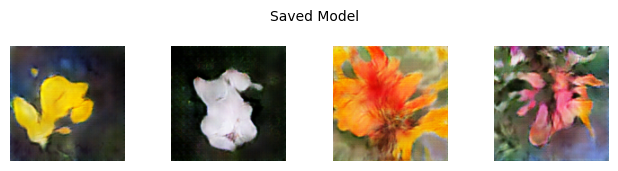

In [326]:
show_examples(saved_model, title="Saved Model")